In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
# drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('eth.csv')
df1=df.reset_index()['Close']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=40,batch_size=64,verbose=1)

Epoch 1/100
24/24 [==============================] - 6s 86ms/step - loss: 0.0547 - val_loss: 0.0040
Epoch 2/100
24/24 [==============================] - 1s 60ms/step - loss: 0.0034 - val_loss: 4.3977e-04
Epoch 3/100
24/24 [==============================] - 1s 49ms/step - loss: 8.8648e-04 - val_loss: 3.1032e-04
Epoch 4/100
24/24 [==============================] - 1s 59ms/step - loss: 7.3018e-04 - val_loss: 2.7145e-04
Epoch 5/100
24/24 [==============================] - 1s 61ms/step - loss: 6.1035e-04 - val_loss: 2.5806e-04
Epoch 6/100
24/24 [==============================] - 1s 58ms/step - loss: 6.1111e-04 - val_loss: 2.4166e-04
Epoch 7/100
24/24 [==============================] - 1s 62ms/step - loss: 6.1195e-04 - val_loss: 2.3467e-04
Epoch 8/100
24/24 [==============================] - 2s 93ms/step - loss: 5.5510e-04 - val_loss: 2.3059e-04
Epoch 9/100
24/24 [==============================] - 2s 76ms/step - loss: 5.3413e-04 - val_loss: 2.5731e-04
Epoch 10/100
24/24 [====================

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 12929 (50.50 KB)
Trainable params: 12929 (50.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

4/4 [==============================] - 0s 12ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [16]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate RMSE
valid_rmse = np.sqrt(mean_squared_error(yval, y_pred_val))
test_rmse = np.sqrt(mean_squared_error(ytest, y_pred))

# Calculate MSE
valid_mse = mean_squared_error(yval, y_pred_val)
test_mse = mean_squared_error(ytest, y_pred)

# Calculate MAE
valid_mae = mean_absolute_error(yval, y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)

# Calculate MAPE
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100

# Print evaluation metrics
print(f"Validation RMSE: {valid_rmse}")
print(f"Testing RMSE: {test_rmse}")
print(f"Validation MSE: {valid_mse}")
print(f"Testing MSE: {test_mse}")
print(f"Validation MAE: {valid_mae}")
print(f"Testing MAE: {test_mae}")
print(f"Validation MAPE: {valid_mape}%")
print(f"Testing MAPE: {test_mape}%")

Validation RMSE: 2295.7546385334103
Testing RMSE: 1606.0672746647094
Validation MSE: 5270489.3603476705
Testing MSE: 2579452.090748927
Validation MAE: 2275.275447583267
Testing MAE: 1586.5792552806286
Validation MAPE: 493002.22614302795%
Testing MAPE: 510044.01083276334%


In [14]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[-100:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.41882604 0.41835762 0.42236402 0.42305377 0.41858509 0.41099828
 0.41563487 0.41152957 0.41631553 0.42363054 0.44024811 0.44616792
 0.45664306 0.46735126 0.45419911 0.48083281 0.48107654 0.47736304
 0.47975049 0.45270105 0.44793332 0.46033039 0.47216055 0.4515924
 0.45319762 0.44675795 0.45115584 0.44282193 0.44790652 0.45586609
 0.47426425 0.47056727 0.46139716 0.46285019 0.45415765 0.48530857
 0.47871481 0.4687999  0.46697553 0.46473468 0.47972199 0.4804641
 0.44977856 0.46210488 0.4620222  0.45630653 0.45233875 0.47564075
 0.47813546 0.52832316 0.53625831 0.51613069 0.52715864 0.50508555
 0.51336059 0.52950504 0.51695755 0.50398093 0.50873575 0.50452459
 0.50120886 0.47094377 0.45610797 0.45460108 0.45124822 0.46171603
 0.46186119 0.45960278 0.47226316 0.47806492 0.46496168 0.4694628
 0.47035399 0.46781586 0.46644266 0.4684188  0.48392566 0.49482786
 0.49401593 0.50831633 0.51121677 0.51255827 0.544401   0.54103141
 0.56973771 0.57956824 0.57519251 0.57159276 0.591121

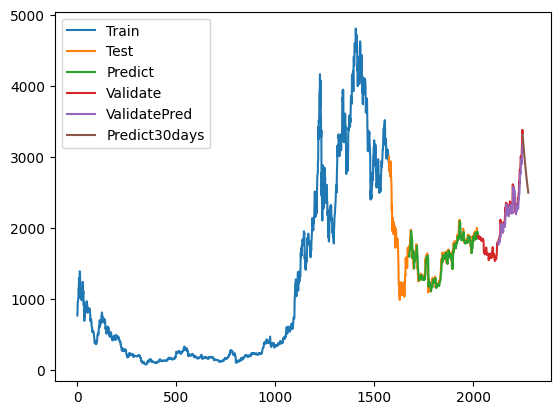

In [15]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()